#  Efficient sampling of unbinned pseudo-Asimov datasets

###  Author: Stephen Menary  (University of Manchester)  [stmenary@cern.ch]

In this notebook we use a toy model to explore the use of importance sampling as method for reducing the sampling variance when estimating the expected sensitivity of an unbinned analysis using the Asimov method. As a toy example, imagine that we have some bimodal data - e.g. a superposition of signal and background events - and we measure one random variable $x$ distributed according to 

$\rho\left(x\right) ~=~ f_1\rho_1\left(x\right) ~+~ \left(1-f_1\right)\cdot\rho_2\left(x\right)$

with

$\rho_1\left(x\right) ~=~ \mathcal{G}~\left(x;~ \mu_1,~ \sigma_1\right)$

$\rho_2\left(x\right) ~=~ \mathcal{G}~\left(x;~ \mu_2,~ \sigma_2\right)$

where $\mathcal{G}(x; \mu, \sigma)$ represents the probability density function of a one-dimensional Gaussian distribution with a mean of $\mu$ and a standard deviation of $\sigma$ evaluated at $x$. Our model is described by the following parameters:
- $f_1$ is the fractional contribution of the total PDF contributed to by the first mode $\rho_1$
- $\mu_1$ and $\sigma_1$ are the Gaussian parameters of $\rho_1$
- $\mu_2$ and $\sigma_2$ are the Gaussian parameters of $\rho_2$

For simplicity, let us assume that $\mu_2$ is the only unknown parameter of our theory, and we wish to estimate this from a measured dataset. We use the profile likelihood ratio test-statistic $q$ to compare two hypothesised values of $\mu_2$, which we label $\mu_2^A$ and $\mu_2^B$. For each datapoint, we compute

$q~\left(x;~\mu_2^A,~\mu_2^B\right) ~=~ -2 ~[~ \log \rho\left(x|\mu_2^A\right) - \log \rho\left(x|\mu_2^B\right) ~]$

and sum this over the entire dataset $X$

$q~\left(X;~\mu_2^A,~\mu_2^B\right) ~=~ \sum_{x\in X}~ q~\left(x;~\mu_2^A,~\mu_2^B\right)$



In [1]:
import sys

import numpy       as np
from   scipy       import stats
from   iminuit     import Minuit
from   matplotlib  import pyplot as plt

In [2]:
f1_true     = 0.9
mu1_true    = -12
sigma1_true = 7

f2_true     = 1 - f1_true
mu2_true    = 1
sigma2_true = 2

In [3]:
def pdf1 (x, mu1=None) :
    if type(mu1) == type(None) : mu1 = mu1_true
    return stats.norm.pdf(x, mu1, sigma1_true)

def pdf2 (x, mu2=None) :
    if type(mu2) == type(None) : mu2 = mu2_true
    return stats.norm.pdf(x, mu2, sigma2_true)

def pdf (x, mu1=None, mu2=None) :
    return f1_true*pdf1(x, mu1) + f2_true*pdf2(x, mu2)

def dpdf_dx (x, mu1=None, mu2=None) :
    if type(mu1) == type(None) : mu1 = mu1_true
    if type(mu2) == type(None) : mu2 = mu2_true
    pdf_1 = f1_true*pdf1(x, mu1)
    pdf_2 = f2_true*pdf2(x, mu2)
    return (mu1-x)*pdf_1/(sigma1_true*sigma1_true) + (mu2-x)*pdf_2/(sigma2_true*sigma2_true)

def q (x, mu1_hyp, mu2_hyp, mu1_ref=None, mu2_ref=None) :
    return -2. * np.log( pdf(x, mu1_hyp, mu2_hyp) / pdf(x, mu1_ref, mu2_ref) )

def q_exp (x, mu1_hyp, mu2_hyp, mu1_ref=None, mu2_ref=None) :
    return pdf(x, mu1_ref, mu2_ref) * q(x, mu1_hyp, mu2_hyp, mu1_ref, mu2_ref)

def q_exp_alt (x, mu1_hyp, mu2_hyp, mu1_ref=None, mu2_ref=None) :
    return pdf(x, mu1_hyp, mu2_hyp) * q(x, mu1_hyp, mu2_hyp, mu1_ref, mu2_ref)

def dq_dx (x, mu1_hyp, mu2_hyp, mu1_ref=None, mu2_ref=None) :
    return -2. * ( (dpdf_dx(x,mu1_hyp,mu2_hyp)/pdf(x,mu1_hyp,mu2_hyp)) - (dpdf_dx(x,mu1_ref,mu2_ref)/pdf(x,mu1_ref,mu2_ref)) )

def importance (x, mu1_hyp, mu2_hyp, mu1_ref=None, mu2_ref=None) :
    return pdf (x, mu1_ref, mu2_ref) * dq_dx (x, mu1_hyp, mu2_hyp, mu1_ref, mu2_ref)

def sample_pdf1 (num, mu1=None) :
    if type(mu1) == type(None) : mu1 = mu1_true
    return mu1 + sigma1_true*np.random.normal(size=(num,))

def sample_pdf2 (num, mu2=None) :
    if type(mu2) == type(None) : mu2 = mu2_true
    return mu2 + sigma2_true*np.random.normal(size=(num,))

def sample (num, mu1=None, mu2=None) :
    num1 = int(num*f1_true)
    num2 = num - num1
    ds1, ds2 = sample_pdf1(num1,mu1), sample_pdf2(num2,mu2)
    ds = np.concatenate([ds1, ds2])
    np.random.shuffle(ds)
    return ds

In [193]:
L      = 100
xsec   = 3
n_exp  = L * xsec
n_as   = int(n_exp * 10000)

chi2_probe_vals = np.linspace(0, 10, 1001)
chi2_cdf        = stats.chi2.cdf(chi2_probe_vals, 1)
edef68, edef95, edef99 = np.interp([0.68, 0.95, 0.99], chi2_cdf, chi2_probe_vals)
print(f"68% errordef is {edef68:.3f}")
print(f"95% errordef is {edef95:.3f}")
print(f"99% errordef is {edef99:.3f}")

print(f"n_exp is {n_exp}")
print(f"n_as is {n_as}")

as_datapoints = sample(n_as)
as_weights    = n_exp / n_as

print("Fitting Asimov")
TNLL_tot = lambda p : -2 * np.sum(as_weights*np.log(pdf(as_datapoints, p[0], p[1])))
m_tot    = Minuit.from_array_func(TNLL_tot, [mu1_true, mu2_true], [0.5, 0.5], errordef=edef95)
m_tot.migrad()

print("Running Minos")
m_tot.minos()
as_val_mu1 , as_val_mu2  = m_tot.values[0], m_tot.values[1]
as_errs_mu1, as_errs_mu2 = m_tot.np_merrors()[:,0], m_tot.np_merrors()[:,1]

print(f"Fit result")
print(f"-  mu1 is {as_val_mu1:.3f} + {as_errs_mu1[1]:.3f} - {as_errs_mu1[0]:.3f}")
print(f"-  mu2 is {as_val_mu2:.3f} + {as_errs_mu2[1]:.3f} - {as_errs_mu2[0]:.3f}")

print("Fitting Asimov (stat only)")
TNLL_stat = lambda p : TNLL_tot([as_val_mu1, p[0]])
m_stat    = Minuit.from_array_func(TNLL_stat, [mu2_true], [0.5], errordef=edef95)
m_stat.migrad()

print("Running Minos (stat only)")
m_stat.minos()
as_val_mu2_stat  = m_stat.values[0]
as_errs_mu2_stat = m_stat.np_merrors()[:,0]

print(f"Fit result")
print(f"-  mu2 is {as_val_mu2_stat:.3f} + {as_errs_mu2_stat[1]:.3f} - {as_errs_mu2_stat[0]:.3f}")

print("Running Minos (stat only, 1sigma)")
m_stat_1sigma = Minuit.from_array_func(TNLL_stat, [mu2_true], [0.5], errordef=1)
m_stat_1sigma.migrad()
m_stat_1sigma.minos()
as_errs_mu2_stat_1sigma = m_stat_1sigma.np_merrors()[:,0]

print("Scanning Asimov")
asimov_curve_tot = []
mu2_scan_points_tot = np.linspace(as_val_mu2-as_errs_mu2[0], as_val_mu2+as_errs_mu2[1], 51)
for mu2_hyp in mu2_scan_points_tot :
    sys.stdout.write(f"\rmu2_hyp is {mu2_hyp:.3f} *****")
    m = Minuit.from_array_func(TNLL_tot, [mu1_true, mu2_hyp], [1, 1], fix=[False,True], errordef=1)
    m.migrad()
    asimov_curve_tot.append(m.get_fmin().fval)
asimov_curve_tot = np.array(asimov_curve_tot)

print("\nScanning Asimov (stat only)")
asimov_curve_stat = []
mu2_scan_points_stat = np.linspace(as_val_mu2_stat-as_errs_mu2_stat[0], as_val_mu2_stat+as_errs_mu2_stat[1], 51)
for mu2_hyp in mu2_scan_points_stat :
    sys.stdout.write(f"\rmu2_hyp is {mu2_hyp:.3f} *****")
    asimov_curve_stat.append(TNLL_stat([mu2_hyp]))
asimov_curve_stat = np.array(asimov_curve_stat)
    

68% errordef is 0.989
95% errordef is 3.841
99% errordef is 6.635
n_exp is 300
n_as is 3000000
Fitting Asimov
Running Minos
Fit result
-  mu1 is -11.999 + 0.902 - 0.912
-  mu2 is 1.000 + 1.114 - 1.152
Fitting Asimov (stat only)
Running Minos (stat only)
Fit result
-  mu2 is 1.000 + 1.110 - 1.149
Running Minos (stat only, 1sigma)
Scanning Asimov
mu2_hyp is 2.115 ******
Scanning Asimov (stat only)
mu2_hyp is 2.111 ******

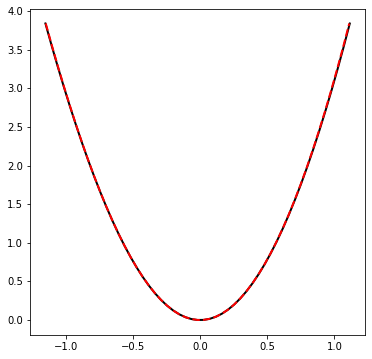

In [194]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(mu2_scan_points_tot  - mu2_true, asimov_curve_tot  - np.min(asimov_curve_tot) , "-", linewidth=2, c="k")
ax.plot(mu2_scan_points_stat - mu2_true, asimov_curve_stat - np.min(asimov_curve_stat), "--", linewidth=2, c="r")
plt.show()

In [195]:
num_asimovs = 100

as_errs_mu2_stat_1sigma_toys = []
for a in range(num_asimovs) :
    print(f"Running ensemble Asimov {a}")
    as_datapoints = sample(n_as)
    as_weights    = n_exp / n_as
    m_stat_1sigma = Minuit.from_array_func(TNLL_stat, [mu2_true], [0.5], errordef=1)
    m_stat_1sigma.migrad()
    m_stat_1sigma.minos()
    as_errs_mu2_stat_1sigma_toys.append(m_stat_1sigma.np_merrors()[:,0])
    print(as_errs_mu2_stat_1sigma_toys[-1])

Running ensemble Asimov 0
[0.57403496 0.56465846]
Running ensemble Asimov 1
[0.57345765 0.56407055]
Running ensemble Asimov 2
[0.5761381  0.56656481]
Running ensemble Asimov 3
[0.57434824 0.56482613]
Running ensemble Asimov 4
[0.57347738 0.56384327]
Running ensemble Asimov 5
[0.57385274 0.56439435]
Running ensemble Asimov 6
[0.57390587 0.56465019]
Running ensemble Asimov 7
[0.57182219 0.56273718]
Running ensemble Asimov 8
[0.57340195 0.56402021]
Running ensemble Asimov 9
[0.57483047 0.56531932]
Running ensemble Asimov 10
[0.57321492 0.56375465]
Running ensemble Asimov 11
[0.57418568 0.56477161]
Running ensemble Asimov 12
[0.57559009 0.56604606]
Running ensemble Asimov 13
[0.57450847 0.56506728]
Running ensemble Asimov 14
[0.57439299 0.56499161]
Running ensemble Asimov 15
[0.57323219 0.56388736]
Running ensemble Asimov 16
[0.57406759 0.56467638]
Running ensemble Asimov 17
[0.57369124 0.56425186]
Running ensemble Asimov 18
[0.57407309 0.56459413]
Running ensemble Asimov 19
[0.5747577  0.

$E_{x\sim p(x|\theta_0)}[q(\theta_0,\theta_1)] ~=~ \int p(x|\theta_0) \cdot q(x|\theta_0, \theta_1) dx$

$~\approx~ \frac{1}{N} \sum_{x\sim p(x|\theta_0)} q(x|\theta_0, \theta_1)$

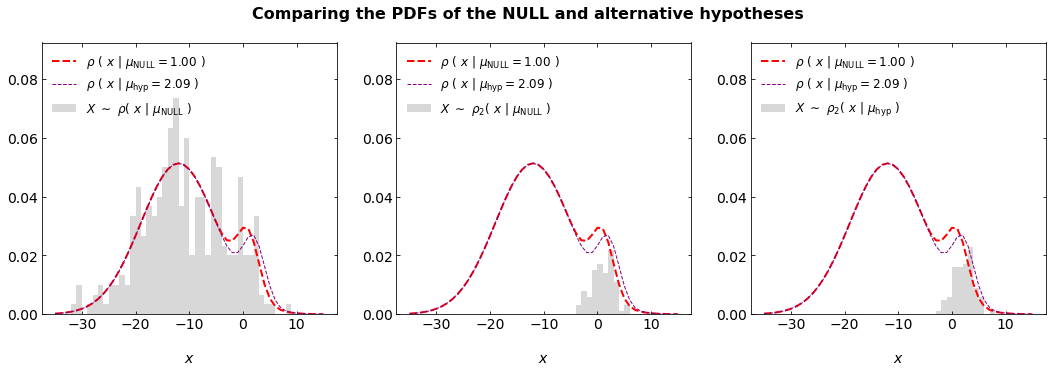

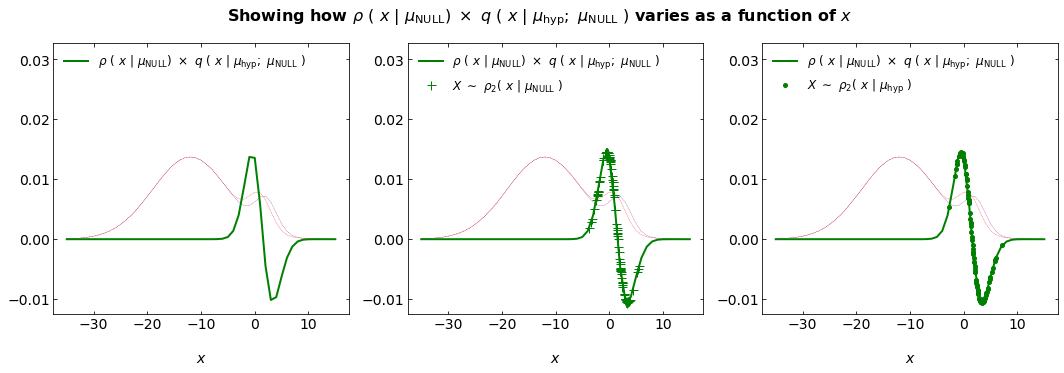

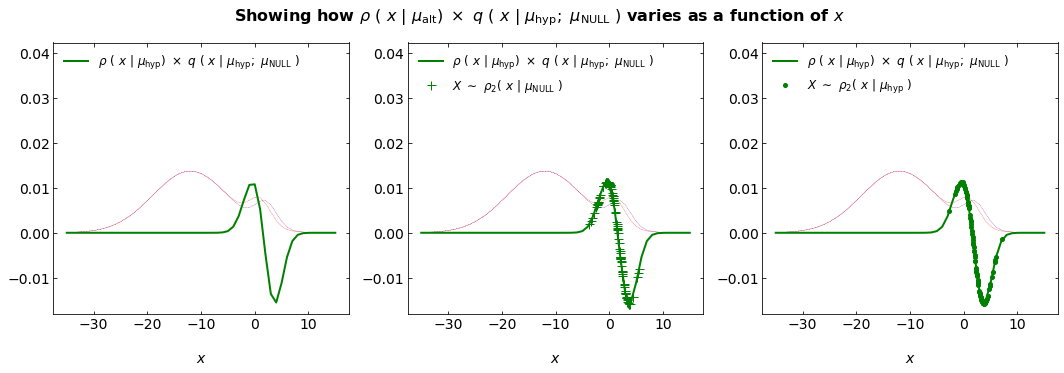

In [6]:
mu2_hyp  = as_val_mu2 + as_errs_mu2[1]
N_per_mu = 100

bins              = np.linspace(-35, 15, 51)
pdf_profile       = pdf       (bins, mu1_true, mu2_true)
pdf_profile_hyp   = pdf       (bins, mu1_true, mu2_hyp)
imp_profile       = importance(bins, mu1_true, mu2_hyp)
q_profile         = q         (bins, mu1_true, mu2_hyp)
dq_profile        = dq_dx     (bins, mu1_true, mu2_hyp)
q_exp_profile     = q_exp     (bins, mu1_true, mu2_hyp)
q_exp_alt_profile = q_exp_alt (bins, mu1_true, mu2_hyp)

pdf_max                      = np.max(np.concatenate([pdf_profile, pdf_profile_hyp]))
q_exp_min, q_exp_max         = np.min(q_exp_profile), np.max(q_exp_profile)
q_exp_range                  = q_exp_max - q_exp_min
q_exp_alt_min, q_exp_alt_max = np.min(q_exp_alt_profile), np.max(q_exp_alt_profile)
q_exp_alt_range              = q_exp_alt_max - q_exp_alt_min
dataset_full                 = sample     (n_exp, mu1_true, mu2_true)
dataset_hyp                  = sample_pdf2(N_per_mu, mu2_hyp)
dataset_true                 = sample_pdf2(N_per_mu)

fig = plt.figure(figsize=(18, 5))
ax  = fig.add_subplot(1, 3, 1)
ax.hist(dataset_full, bins=bins, weights=np.full(shape=(n_exp,), fill_value=1/n_exp/(bins[1]-bins[0])), density=False, color="grey", alpha=0.3, label=r"$X~\sim~\rho (~x~|~\mu_{\rm NULL}~)$")
ax.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL} = "+f"{mu2_true:.2f}$ )")
ax.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1, label=r"$\rho~(~x~|~\mu_{\rm hyp} = "+f"{mu2_hyp:.2f}$ )")
ax.set_ylim([0, 1.8*pdf_max])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 2)
ax.hist(dataset_true, bins=bins, weights=np.full(shape=(N_per_mu,), fill_value=f2_true/N_per_mu/(bins[1]-bins[0])), density=False, color="grey", alpha=0.3, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL} = "+f"{mu2_true:.2f}$ )")
ax.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1, label=r"$\rho~(~x~|~\mu_{\rm hyp} = "+f"{mu2_hyp:.2f}$ )")
ax.set_ylim([0, 1.8*pdf_max])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 3)
ax.hist(dataset_hyp , bins=bins, weights=np.full(shape=(N_per_mu,), fill_value=f2_true/N_per_mu/(bins[1]-bins[0])), density=False, color="grey", alpha=0.3, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL} = "+f"{mu2_true:.2f}$ )")
ax.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1, label=r"$\rho~(~x~|~\mu_{\rm hyp} = "+f"{mu2_hyp:.2f}$ )")
ax.set_ylim([0, 1.8*pdf_max])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle("Comparing the PDFs of the NULL and alternative hypotheses", weight="bold", fontsize=16)
plt.show()

fig = plt.figure(figsize=(18, 5))
ax  = fig.add_subplot(1, 3, 1)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 2)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_true, q_exp(dataset_true, mu1_true, mu2_hyp, mu1_true, mu2_true), "+", c="g", markersize=9, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 3)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_hyp , q_exp(dataset_hyp , mu1_true, mu2_hyp, mu1_true, mu2_true), "o", c="g", markersize=4, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle(r"Showing how $\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$ varies as a function of $x$", weight="bold", fontsize=16)
plt.show()

fig = plt.figure(figsize=(18, 5))
ax  = fig.add_subplot(1, 3, 1)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 2)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_true, q_exp_alt(dataset_true, mu1_true, mu2_hyp, mu1_true, mu2_true), "+", c="g", markersize=9, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 3)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_hyp , q_exp_alt(dataset_hyp , mu1_true, mu2_hyp, mu1_true, mu2_true), "o", c="g", markersize=4, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle(r"Showing how $\rho~(~x~|~\mu_{\rm alt})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$ varies as a function of $x$", weight="bold", fontsize=16)
plt.show()


In [21]:
n_toys = [300, 500, 1000, 3000, 5000, 10000, 30000, 50000, 100000]
num_toys = 1000

mu2_fit_results = {}
for n_toy in n_toys :
    sys.stdout.write(f"\rnum toys is {n_toy}")
    mu2_fit_results [n_toy] = []
    for toy_idx in range(num_toys) :
        sys.stdout.write(f"\rtoy size is {n_toy}, number is {toy_idx+1} / {num_toys} ********")
        toy_datapoints = sample(n_toy)
        toy_weights    = n_exp / n_toy
        TNLL = lambda p : -2 * np.sum(toy_weights*np.log(pdf(toy_datapoints, mu1_true, p[0])))
        m = Minuit.from_array_func(TNLL, [mu2_true], [1], errordef=1)
        m.migrad()
        if not m.get_fmin().is_valid :
            n_toy = n_toy - 1
            continue
        m.minos()
        mu2_fit_results [n_toy].append([m.values[0], np.mean(m.np_merrors()[:,0])])
        

toy size is 100000, number is 1000 / 1000 ********

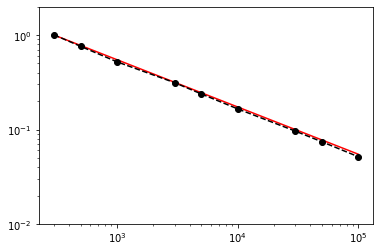

In [103]:
ref_std = np.mean([as_errs_mu2_stat_1sigma[0], as_errs_mu2_stat_1sigma[1]])

y_mean, y_std, y_mean_err, y_width, y_width_err = [], [], [], [], []
for n_toy in n_toys :
    fit_result_est   = [x[0] for x in mu2_fit_results [n_toy]]
    fit_result_width = [x[1] for x in mu2_fit_results [n_toy]]
    est_mean   = np.mean(fit_result_est)
    est_std    = np.std (fit_result_est)
    width_mean = np.mean(fit_result_width)
    width_std  = np.std (fit_result_width)
    y_mean     .append(est_mean)
    y_std      .append(est_std)
    y_width    .append(width_mean)
    y_mean_err .append(est_std  / np.sqrt(num_toys))
    y_width_err.append(width_std/ np.sqrt(num_toys))
y_mean, y_std, y_mean_err, y_width, y_width_err = np.array(y_mean), np.array(y_std), np.array(y_mean_err), np.array(y_width), np.array(y_width_err)

plt.plot(n_toys, np.sqrt(n_exp/np.array(n_toys)), "-", c="r")
plt.plot(n_toys, y_std/ref_std, "o-", c="k", linestyle="--")
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim([0.01, 2])
plt.show()

toy size is 300, number is 1000 / 1000 ********

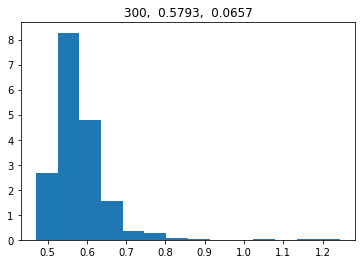

toy size is 500, number is 1000 / 1000 ********

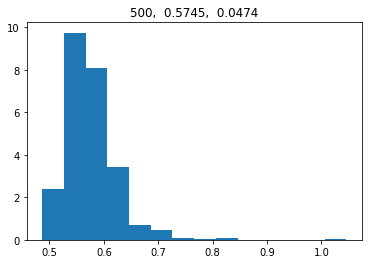

toy size is 1000, number is 1000 / 1000 ********

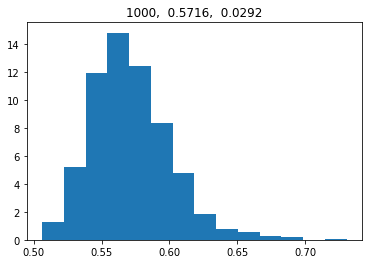

toy size is 3000, number is 1000 / 1000 ********

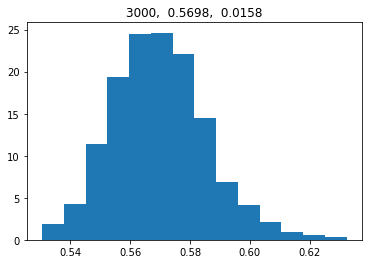

toy size is 5000, number is 1000 / 1000 ********

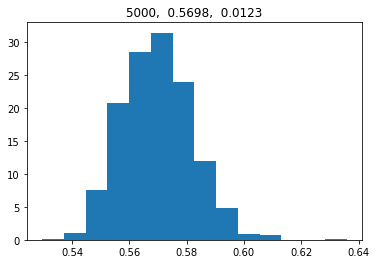

toy size is 10000, number is 1000 / 1000 ********

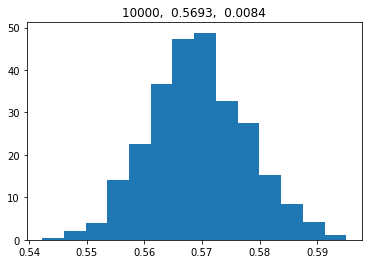

toy size is 30000, number is 1000 / 1000 ********

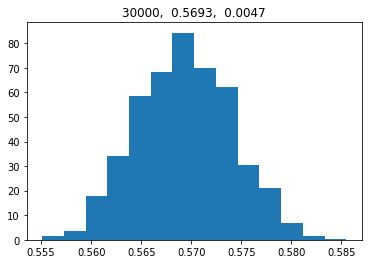

toy size is 50000, number is 1000 / 1000 ********

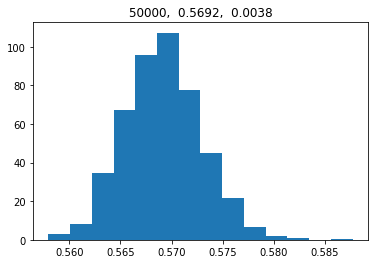

toy size is 100000, number is 1000 / 1000 ********

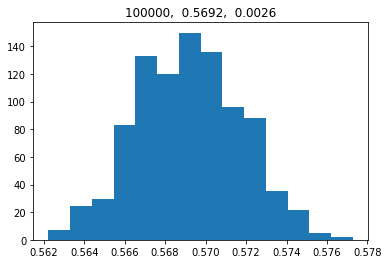

In [161]:
mu2_fit_results_imp_samp = {}
for n_toy in n_toys :
    sys.stdout.write(f"\rnum toys is {n_toy}")
    mu2_fit_results_imp_samp [n_toy] = []
    for toy_idx in range(num_toys) :
        sys.stdout.write(f"\rtoy size is {n_toy}, number is {toy_idx+1} / {num_toys} ********")
        toy_datapoints = sample_pdf2(n_toy)
        toy_weights    = (n_exp / n_toy) * pdf(toy_datapoints) / pdf2(toy_datapoints)
        TNLL = lambda p : -2 * np.sum(toy_weights*np.log(pdf(toy_datapoints, mu1_true, p[0])))
        m = Minuit.from_array_func(TNLL, [mu2_true], [1], errordef=1)
        m.migrad()
        if (not m.get_fmin().is_valid) or (np.fabs(m.values[0]-mu2_true) > 2) :
            toy_idx = toy_idx - 1
            continue
        m.minos()
        best, width = m.values[0], np.mean(m.np_merrors()[:,0])
        if np.mean(m.np_merrors()[:,0]) > 0.7 :
            x = np.linspace(best, best-2*m.np_merrors()[1,0], 51)
            y = [TNLL([xp]) for xp in x]
            width = best - np.interp(1, y-np.min(y), x)
            x = np.linspace(best, best+2*m.np_merrors()[0,0], 51)
            y = [TNLL([xp]) for xp in x]
            width = np.mean([width, np.interp(1, y-np.min(y), x) - best])
        mu2_fit_results_imp_samp [n_toy].append([best, width])
    fit_result_est   = [x[0] for x in mu2_fit_results_imp_samp [n_toy]]
    fit_result_width = [x[1] for x in mu2_fit_results_imp_samp [n_toy]]
    '''est_mean = np.mean(fit_result_est)
    to_plot  = np.array(fit_result_est)-mu2_true
    plt.hist(to_plot, bins=np.linspace(np.min(to_plot), np.max(to_plot), max(15, 1+int(np.max(to_plot)-np.min(to_plot)/0.1))), density=True)
    plt.gca().set_title(f"{n_toy},  {est_mean-mu2_true:.4f},  {est_std:.4f}")
    plt.show()'''
    plt.hist(fit_result_width, bins=np.linspace(np.min(fit_result_width), np.max(fit_result_width), max(15, 1+int(np.max(fit_result_width)-np.min(fit_result_width)/0.1))), density=True)
    plt.gca().set_title(f"{n_toy},  {np.mean(fit_result_width):.4f},  {np.std(fit_result_width):.4f}")
    plt.show()
        

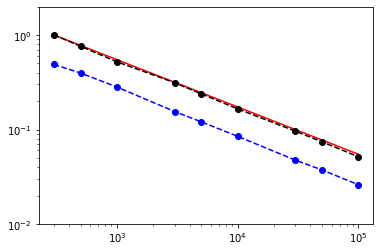

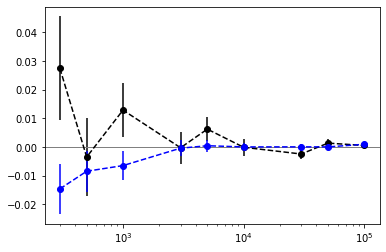

In [162]:

y2_mean, y2_std, y2_mean_err, y2_width, y2_width_err = [], [], [], [], []
for n_toy in n_toys :
    fit_result_est   = [x[0] for x in mu2_fit_results_imp_samp [n_toy]]
    fit_result_width = [x[1] for x in mu2_fit_results_imp_samp [n_toy]]
    est_mean   = np.mean(fit_result_est)
    est_std    = np.std (fit_result_est)
    width_mean = np.mean(fit_result_width)
    width_std  = np.std (fit_result_width)
    y2_mean     .append(est_mean)
    y2_std      .append(est_std)
    y2_width    .append(width_mean)
    y2_mean_err .append(est_std  / np.sqrt(num_toys))
    y2_width_err.append(width_std/ np.sqrt(num_toys))
y2_mean, y2_std, y2_mean_err, y2_width, y2_width_err = np.array(y2_mean), np.array(y2_std), np.array(y2_mean_err), np.array(y2_width), np.array(y2_width_err)

plt.plot(n_toys, np.sqrt(n_exp/np.array(n_toys)), "-", c="r")
plt.errorbar(n_toys, y_std /ref_std, yerr=(y_std /ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="k")
plt.errorbar(n_toys, y2_std/ref_std, yerr=(y2_std/ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="b")
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim([0.01, 2])
plt.show()

plt.errorbar(n_toys, y_mean  - mu2_true, yerr=y_mean_err , fmt="o--", c="k")
plt.errorbar(n_toys, y2_mean - mu2_true, yerr=y2_mean_err, fmt="o--", c="b")
plt.gca().set_xscale("log")
plt.gca().axhline(0, linestyle="-", c="grey", linewidth=1)
plt.show()


In [52]:
n_test   = int(n_exp)
mu2_test = mu2_true + as_errs_mu2_stat_1sigma[1]

print(f"n_test is {n_test}")

toy_datapoints = sample_pdf2 (n_test)
toy_weights    = (n_exp / n_test) * pdf(toy_datapoints) / pdf2(toy_datapoints)
importance     = q (toy_datapoints, mu1_true, mu2_test)
exp_importance = importance * pdf(toy_datapoints)

n_g       = 2
sigma_min = 1e-2

def model_prob (x, params, i=-1) :
    means       = params[     :n_g  ]
    sigmas      = 1e-2 + np.exp(params[n_g  :2*n_g])
    frequencies = params[2*n_g:     ]
    frequencies = np.concatenate([frequencies, [1-np.sum(frequencies)]])
    prob = 0.
    if i < 0 :
        for i in range(n_g) :
            prob = prob + frequencies[i] * stats.norm.pdf(x, means[i], sigmas[i])
    else :
        prob = prob + frequencies[i] * stats.norm.pdf(x, means[i], sigmas[i])
    return prob
    
def loss (params) :
    logL_dp = np.log(model_prob (toy_datapoints, params))
    logL    = np.sum(np.fabs(importance) * toy_weights * logL_dp)
    return - logL

dp_min, dp_max = np.min(toy_datapoints), np.max(toy_datapoints)
dp_range       = dp_max - dp_min
start_means  = np.linspace(dp_min, dp_max, n_g+2)[1:-1]
start_sigmas = np.full(shape=(n_g  ), fill_value=np.log(dp_range/n_g/4))
start_freq   = np.full(shape=(n_g-1), fill_value=1       /n_g)
start_params = np.concatenate([start_means, start_sigmas, start_freq])

m = Minuit.from_array_func(loss, start_params, start_params, errordef=1)
m.migrad()
end_params = m.np_values()
print("Fit complete")

scan_x  = np.linspace(dp_min-0.5*dp_range, dp_max+0.5*dp_range, 101)
scan_y  = model_prob(scan_x, start_params)
indiv_y = [model_prob(scan_x, start_params, i) for i in range(n_g)]

n_test is 300
Fit complete


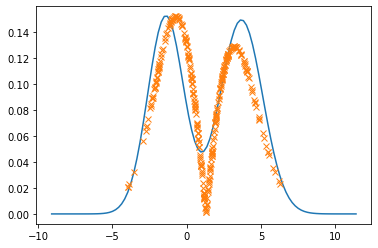

In [53]:

scan_y = model_prob(scan_x, end_params)
plt.plot(scan_x, scan_y)
plt.plot(toy_datapoints, np.fabs(exp_importance)*np.max(scan_y)/np.max(np.fabs(exp_importance)), "x")
plt.show()

In [57]:

def sample_model_prob (num_pts, params, i=-1) :
    means         = params[     :n_g  ]
    sigmas        = sigma_min + np.exp(params[n_g  :2*n_g])
    frequencies   = params[2*n_g:     ]
    frequencies   = np.concatenate([frequencies, [1-np.sum(frequencies)]])
    if i < 0 :
        gauss_choices = np.random.choice(n_g, p=frequencies, size=(num_pts,))
    else :
        gauss_choices = np.full(shape=(num_pts,), fill_value=i)
    datapoints    = []
    for i in range(n_g) :
        num_i = len([True for c in gauss_choices if c==i])
        datapoints.append(means[i] + sigmas[i]*np.random.normal(size=(num_i,)))
    ret = np.concatenate(datapoints)
    np.random.shuffle(ret)
    return ret


toy size is 300, number is 1000 / 1000 ********

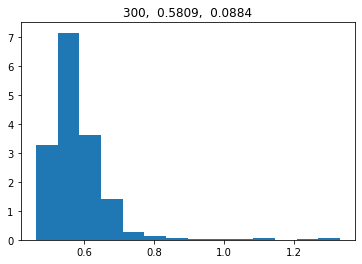

toy size is 500, number is 1000 / 1000 ********

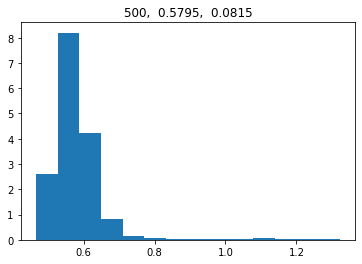

toy size is 1000, number is 1000 / 1000 ********

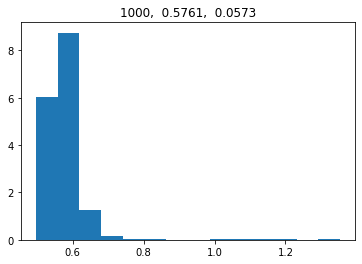

toy size is 3000, number is 1000 / 1000 ********

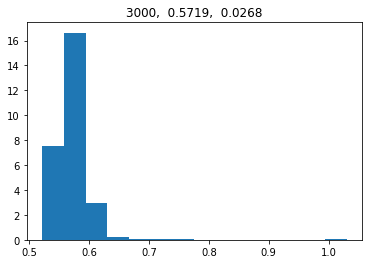

toy size is 5000, number is 1000 / 1000 ********

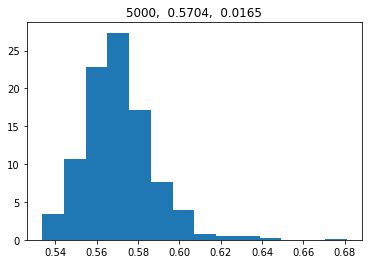

toy size is 10000, number is 1000 / 1000 ********

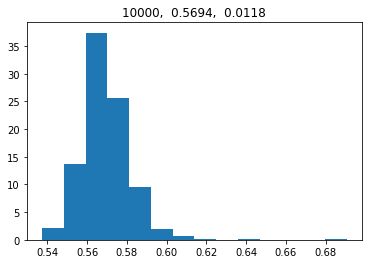

toy size is 30000, number is 1000 / 1000 ********

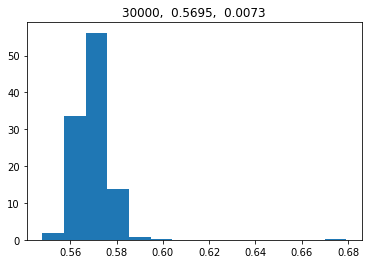

toy size is 50000, number is 1000 / 1000 ********

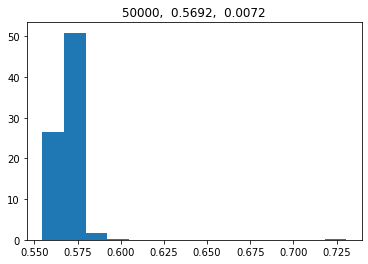

toy size is 100000, number is 1000 / 1000 ********

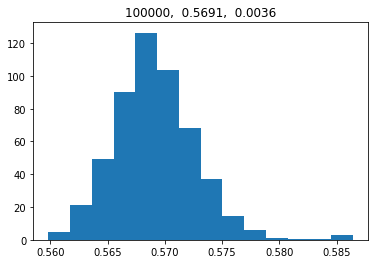

In [167]:

mu2_fit_results_optimal = {}
for n_toy in n_toys :
    sys.stdout.write(f"\rnum toys is {n_toy}")
    mu2_fit_results_optimal [n_toy] = []
    for toy_idx in range(num_toys) :
        sys.stdout.write(f"\rtoy size is {n_toy}, number is {toy_idx+1} / {num_toys} ********")
        toy_datapoints = sample_model_prob(n_toy, end_params)
        toy_weights    = (n_exp / n_toy) * pdf(toy_datapoints) / model_prob(toy_datapoints, end_params)
        TNLL = lambda p : -2 * np.sum(toy_weights*np.log(pdf(toy_datapoints, mu1_true, p[0])))
        m = Minuit.from_array_func(TNLL, [mu2_true], [1], errordef=1)
        m.migrad()
        if (not m.get_fmin().is_valid) or (np.fabs(m.values[0]-mu2_true) > 2) :
            toy_idx = toy_idx - 1
            continue
        m.minos()
        best, width = m.values[0], np.mean(m.np_merrors()[:,0])
        if np.mean(m.np_merrors()[:,0]) > 0.7 :
            x = np.linspace(best, best-2*m.np_merrors()[1,0], 51)
            y = [TNLL([xp]) for xp in x]
            width = best - np.interp(1, y-np.min(y), x)
            x = np.linspace(best, best+2*m.np_merrors()[0,0], 51)
            y = [TNLL([xp]) for xp in x]
            width = np.mean([width, np.interp(1, y-np.min(y), x) - best])
        mu2_fit_results_optimal [n_toy].append([best, width])
    fit_result_est   = [x[0] for x in mu2_fit_results_optimal [n_toy]]
    fit_result_width = [x[1] for x in mu2_fit_results_optimal [n_toy]]
    '''est_mean = np.mean(fit_result_est)
    to_plot  = np.array(fit_result_est)-mu2_true
    plt.hist(to_plot, bins=np.linspace(np.min(to_plot), np.max(to_plot), max(15, 1+int(np.max(to_plot)-np.min(to_plot)/0.1))), density=True)
    plt.gca().set_title(f"{n_toy},  {est_mean-mu2_true:.4f},  {est_std:.4f}")
    plt.show()'''
    plt.hist(fit_result_width, bins=np.linspace(np.min(fit_result_width), np.max(fit_result_width), max(15, 1+int(np.max(fit_result_width)-np.min(fit_result_width)/0.1))), density=True)
    plt.gca().set_title(f"{n_toy},  {np.mean(fit_result_width):.4f},  {np.std(fit_result_width):.4f}")
    plt.show()

In [168]:

y3_mean, y3_std, y3_mean_err, y3_width, y3_width_err = [], [], [], [], []
for n_toy in n_toys :
    fit_result_est   = [x[0] for x in mu2_fit_results_optimal [n_toy]]
    fit_result_width = [x[1] for x in mu2_fit_results_optimal [n_toy]]
    est_mean   = np.mean(fit_result_est)
    est_std    = np.std (fit_result_est)
    width_mean = np.mean(fit_result_width)
    width_std  = np.std (fit_result_width)
    y3_mean     .append(est_mean)
    y3_std      .append(est_std)
    y3_width    .append(width_mean)
    y3_mean_err .append(est_std  / np.sqrt(num_toys))
    y3_width_err.append(width_std/ np.sqrt(num_toys))
y3_mean, y3_std, y3_mean_err, y3_width, y3_width_err = np.array(y3_mean), np.array(y3_std), np.array(y3_mean_err), np.array(y3_width), np.array(y3_width_err)


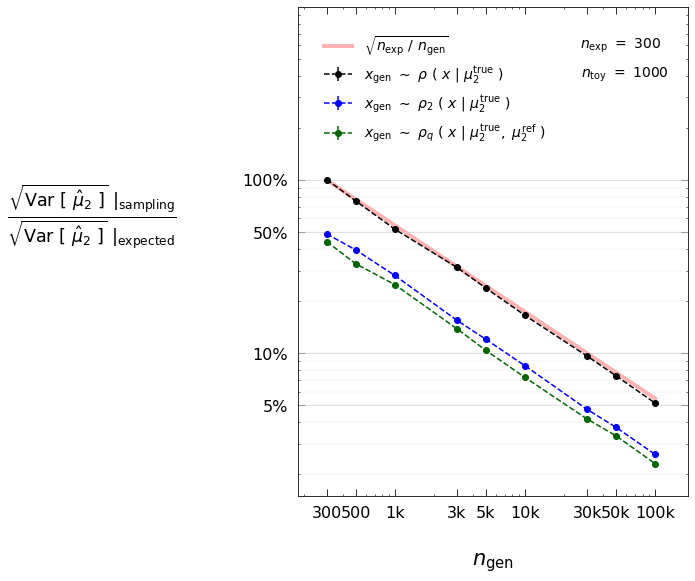

In [169]:
fig = plt.figure(figsize=(7, 9))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(n_toys, np.sqrt(n_exp/np.array(n_toys)), "-", c="r", alpha=0.3, linewidth=4, label=r"$\sqrt{n_{\rm exp}~/~n_{\rm gen}}$")
ax.errorbar(n_toys, y_std /ref_std, yerr=(y_std /ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="k"        , label=r"$x_{\rm gen}~\sim~\rho~(~x~|~\mu_2^{\rm true}~)$")
ax.errorbar(n_toys, y2_std/ref_std, yerr=(y2_std/ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="b"        , label=r"$x_{\rm gen}~\sim~\rho_2~(~x~|~\mu_2^{\rm true}~)$")
ax.errorbar(n_toys, y3_std/ref_std, yerr=(y3_std/ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="darkgreen", label=r"$x_{\rm gen}~\sim~\rho_q~(~x~|~\mu_2^{\rm true},~\mu_2^{\rm ref}~)$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([180, 180000])
ax.set_ylim([0.015, 10])
ax.set_yticks     ([5e-2, 1e-1 , 5e-1 , 1])
ax.set_yticklabels(["5%", "10%", "50%", "100%"])
ax.set_xticks     (n_toys)
xticklabels = []
for n_toy in n_toys :
    if n_toy > 999999 :
        xticklabels.append(f"{int(n_toy/1000000)}M")
        continue
    if n_toy > 999 : 
        xticklabels.append(f"{int(n_toy/1000)}k")
        continue
    xticklabels.append(f"{int(n_toy)}")
ax.set_xticklabels(xticklabels)
ax.tick_params(axis="both", which="both", direction="in", right=True, top=True, labelsize=16, pad=10)
ax.tick_params(axis="both", which="major", length=7)
ax.legend(loc="upper left", fontsize=14, borderaxespad=1.5, facecolor="white", edgecolor="white", framealpha=1)
#ax.set_ylabel(r"$\frac{\sqrt{\mathbb{E}_{x_{\rm gen}}[(\hat \mu_2(x) - \langle\hat \mu_2(x)\rangle)^2]}}{\sqrt{\mathbb{E}_{x_{\rm asimov}}[(\hat \mu_2(x) - \langle\hat \mu_2(x)\rangle)^2]}}$", rotation=0, fontsize=25, labelpad=150)
ax.set_ylabel(r"$\frac{{\sqrt{{\rm Var}~[~\hat \mu_2~]}}~|_{\rm sampling}}{{\sqrt{{\rm Var}~[~\hat \mu_2~]}}~|_{\rm expected}}$", rotation=0, fontsize=25, labelpad=150)
#ax.set_ylabel(r"$\frac{\sqrt{{\rm Sampling~variance}}}{\sqrt{{\rm Expected~variance}}}$", rotation=0, fontsize=25, labelpad=100)
#ax.set_ylabel(r"$\frac{\Delta~\mu_2^{\rm ~sampling}}{\Delta~\mu_2^{\rm ~expected}}$", rotation=0, fontsize=25, labelpad=80)
ax.set_xlabel(r"$n_{\rm gen}$", rotation=0, fontsize=21, labelpad=30)

minor_y = np.concatenate([[0.01*i for i in range(10)], [0.1*i for i in range(10)], [1]])
major_y =[0.05, 0.1, 0.5, 1]
for y in minor_y : ax.axhline(y, linewidth=0.2, linestyle="-", c="lightgrey")
for y in major_y : ax.axhline(y, linewidth=0.6, linestyle="-", c="lightgrey")
    
ax.text(0.93, 0.94, r"$n_{\rm exp} ~=~ "+f"{n_exp   :.0f}$", transform=ax.transAxes, ha="right", va="top", fontsize=14)
ax.text(0.95, 0.88, r"$n_{\rm toy} ~=~ "+f"{num_toys:.0f}$", transform=ax.transAxes, ha="right", va="top", fontsize=14)
plt.show()

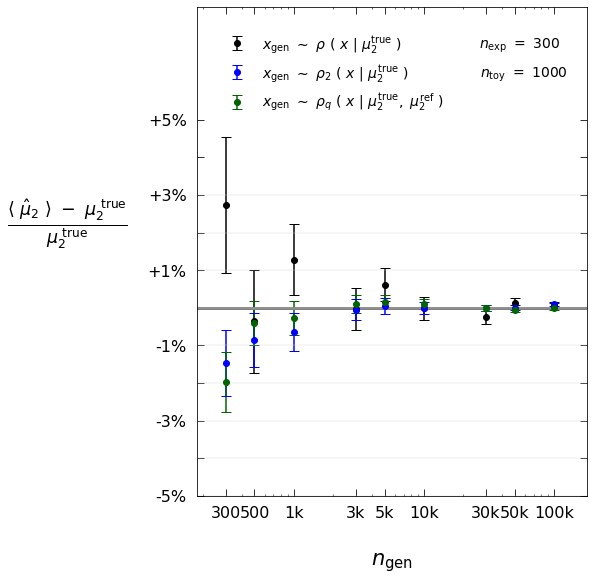

In [197]:
fig = plt.figure(figsize=(7, 9))
ax  = fig.add_subplot(1, 1, 1)
ax.errorbar(n_toys, y_mean  - mu2_true, yerr=y_mean_err , fmt="o", capsize=5, c="k"        , label=r"$x_{\rm gen}~\sim~\rho~(~x~|~\mu_2^{\rm true}~)$")
ax.errorbar(n_toys, y2_mean - mu2_true, yerr=y2_mean_err, fmt="o", capsize=5, c="b"        , label=r"$x_{\rm gen}~\sim~\rho_2~(~x~|~\mu_2^{\rm true}~)$")
ax.errorbar(n_toys, y3_mean - mu2_true, yerr=y3_mean_err, fmt="o", capsize=5, c="darkgreen", label=r"$x_{\rm gen}~\sim~\rho_q~(~x~|~\mu_2^{\rm true},~\mu_2^{\rm ref}~)$")
ax.axhline (0, linewidth=3, c="grey")
ax.set_xscale("log")
ax.set_xlim([180, 180000])
ax.set_ylim([-0.05, 0.08])
ax.set_yticks     ([-0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticklabels(["-5%", "", "-3%", "", "-1%", "", "+1%", "", "+3%", "", "+5%"])
ax.set_xticks     (n_toys)
xticklabels = []
for n_toy in n_toys :
    if n_toy > 999999 :
        xticklabels.append(f"{int(n_toy/1000000)}M")
        continue
    if n_toy > 999 : 
        xticklabels.append(f"{int(n_toy/1000)}k")
        continue
    xticklabels.append(f"{int(n_toy)}")
ax.set_xticklabels(xticklabels)
ax.tick_params(axis="both", which="both", direction="in", right=True, top=True, labelsize=16, pad=10)
ax.tick_params(axis="both", which="major", length=7)
ax.legend(loc="upper left", fontsize=14, borderaxespad=1.5, facecolor="white", edgecolor="white", framealpha=1)
ax.set_xlabel(r"$n_{\rm gen}$", rotation=0, fontsize=21, labelpad=30)
ax.set_ylabel(r"$\frac{\langle~\hat\mu_2~\rangle~-~\mu_2^{\rm ~true}}{\mu_2^{\rm ~true}}$", rotation=0, fontsize=25, labelpad=80)

minor_y = [0.03, 0.02, 0.01, 0, -0.01, -0.02, -0.03, -0.04, -0.05]
for y in minor_y : ax.axhline(y, linewidth=0.4, linestyle="-", c="lightgrey")
    
ax.text(0.93, 0.94, r"$n_{\rm exp} ~=~ "+f"{n_exp   :.0f}$", transform=ax.transAxes, ha="right", va="top", fontsize=14)
ax.text(0.95, 0.88, r"$n_{\rm toy} ~=~ "+f"{num_toys:.0f}$", transform=ax.transAxes, ha="right", va="top", fontsize=14)
plt.show()


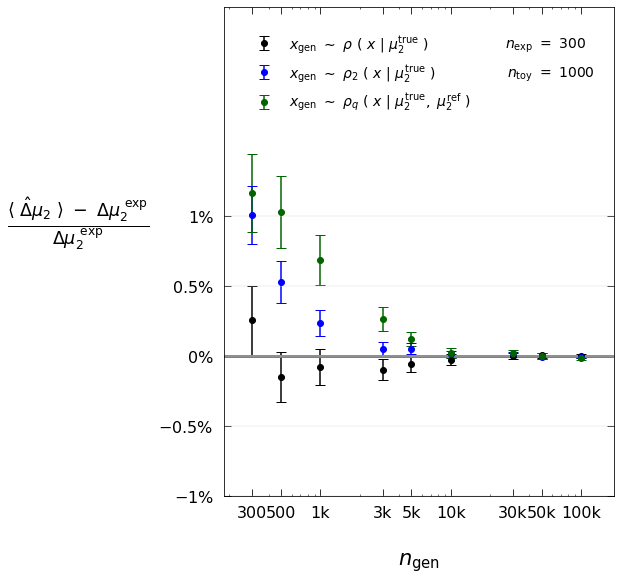

In [196]:
mu2_exp_width = np.mean(as_errs_mu2_stat_1sigma_toys)

fig = plt.figure(figsize=(7, 9))
ax  = fig.add_subplot(1, 1, 1)
ax.errorbar(n_toys, y_width  - mu2_exp_width, yerr=y_width_err , fmt="o", capsize=5, c="k"        , label=r"$x_{\rm gen}~\sim~\rho~(~x~|~\mu_2^{\rm true}~)$")
ax.errorbar(n_toys, y2_width - mu2_exp_width, yerr=y2_width_err, fmt="o", capsize=5, c="b"        , label=r"$x_{\rm gen}~\sim~\rho_2~(~x~|~\mu_2^{\rm true}~)$")
ax.errorbar(n_toys, y3_width - mu2_exp_width, yerr=y3_width_err, fmt="o", capsize=5, c="darkgreen", label=r"$x_{\rm gen}~\sim~\rho_q~(~x~|~\mu_2^{\rm true},~\mu_2^{\rm ref}~)$")
ax.axhline (0, linewidth=3, c="grey")
ax.set_xscale("log")
ax.set_xlim([180, 180000])
ax.set_ylim([-0.01, 0.025])
ax.set_yticks     ([-0.01, -0.005, 0, 0.005, 0.01])
ax.set_yticklabels(["$-1$%", r"$-0.5$%", "0%", r"$0.5$%", "1%"])
ax.set_xticks     (n_toys)
xticklabels = []
for n_toy in n_toys :
    if n_toy > 999999 :
        xticklabels.append(f"{int(n_toy/1000000)}M")
        continue
    if n_toy > 999 : 
        xticklabels.append(f"{int(n_toy/1000)}k")
        continue
    xticklabels.append(f"{int(n_toy)}")
ax.set_xticklabels(xticklabels)
ax.tick_params(axis="both", which="both", direction="in", right=True, top=True, labelsize=16, pad=10)
ax.tick_params(axis="both", which="major", length=7)
ax.legend(loc="upper left", fontsize=14, borderaxespad=1.5, facecolor="white", edgecolor="white", framealpha=1)
ax.set_xlabel(r"$n_{\rm gen}$", rotation=0, fontsize=21, labelpad=30)
ax.set_ylabel(r"$\frac{\langle~\hat\Delta\mu_2~\rangle~-~\Delta\mu_2^{\rm ~exp}}{\Delta\mu_2^{\rm ~exp}}$", rotation=0, fontsize=25, labelpad=80)

minor_y = [-0.01, -0.005, 0, 0.005, 0.01]
for y in minor_y : ax.axhline(y, linewidth=0.4, linestyle="-", c="lightgrey")
    
ax.text(0.93, 0.94, r"$n_{\rm exp} ~=~ "+f"{n_exp   :.0f}$", transform=ax.transAxes, ha="right", va="top", fontsize=14)
ax.text(0.95, 0.88, r"$n_{\rm toy} ~=~ "+f"{num_toys:.0f}$", transform=ax.transAxes, ha="right", va="top", fontsize=14)
plt.show()
